# Supporting Information:Understanding Associative Polymer Self-Assembly with Shrinking Gate Fluorescence Correlation Spectroscopy
## Timothy J. Murdoch, Baptiste Quienne, Julien Pinaud, Sylvain Caillol and Ignacio Martín-Fabiani

This Jupyter notebook outlines the processing of shrinking gate fluorescence correlation spectroscopy (sgFCS) data collected via time-correlated single photon counting on a PicoQuant MT200 confocal microscope. It describes the data importing, sgFCS processing to generate a family of autocorrelation curves, and subsequent curve fitting combined with Markov chain Monte Carlo (MCMC) sampling to determine uncertainties. 

## Imports

### External Packages

In [91]:
import pylab as plt
import pandas as pd
from lmfit import Model, Parameters
from lmfit.models import ConstantModel
%load_ext autoreload
%autoreload 2
from matplotlib import ticker
%matplotlib inline
import corner

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Internal Scripts
Internal scripts for processing also utilise code modified from the following repositories

https://github.com/SumeetRohilla/readPTU_FLIM

https://github.com/dwaithe/FCS_point_correlator
```python
from readPTU_FLIM import PTUreader
from focuspoint.correlation_methods.correlation_methods import tttr2xfcs
```

In [69]:
#Create pointer to PTU_importer package
import sys
path = '../Scripts/'
sys.path.insert(0, path)
# from readPTU_FLIM import * #readPTU_FLIM.py needs to be in current folder or in //lib/site-packages
from fcs import *
from fcs_fitting import *

## Load and Store Decays
Batch sgFCS processing and fitting are both run from a dataframe imported from an excel file containing two columns.
- paths: a list of relative or absolute paths to the raw dat (*.ptu)
- pickle_name: a list of string to generate names of storing results using Python's pickle library

The load_decays function calculates intensity vs macrotime (s), and total counts vs microtime (ns) for each decay in the dataframe

In [70]:
#Load a list of files
file = 'filenames_ibidi_Conc_full.xlsx'
df = pd.read_excel(file)
df

,paths,pickle_name
0,../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_...,0_01wtHC12_12nMsCy3_230607
1,../../2023/230608_clean_ibidi_ctd.sptw/HC12_0_...,0_1wtHC12_12nMsCy3_230608
2,../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_...,0_16wtHC12_12nMsCy3_230607
3,../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_...,0_25wtHC12_12nMsCy3_230607
4,../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_...,0_4wtHC12_12nMsCy3_230607
5,../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_...,0_63wtHC12_12nMsCy3_230607
6,../../2023/230607_clean_ibidi_fcs.sptw/HC12_1w...,1wtHC12_12nMsCy3_230607
7,../../2023/230420_ibidi_FCS.sptw/HC12_2_1.ptu,2wtHC12_25nMsCy3_230420
8,../../2023/230420_ibidi_FCS.sptw/HC12_5_1.ptu,5wtHC12_25nMsCy3_230420


In [11]:
#import data and create arrays containing the intensity (cps), macro_time (s), lifetime decays (cts), and decay microtime (ns)
int_cps, int_times, decays, decay_times = load_decays(df)

#store imported decays as a binary pickle to make importing faster in future
with open('decays_supp.bin','wb') as f:
    pickle.dump((int_cps, int_times, decays, decay_times),f)

../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_01wt_sCy3_ibidi_1.ptu
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

../../2023/230608_clean_ibidi_ctd.sptw/HC12_0_1_wt_ibidi_2.ptu
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_16wt_sCy3_ibidi_1.ptu
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_25wt_sCy3_ibidi_1.ptu
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_4wt_sCy3_ibidi_1.ptu
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

../../2023/230607_clean_ibidi_fcs.sptw/HC12_0_63wt_sCy3_ibidi_1.ptu
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

../../2023/230607_clean_ibidi_fcs.sptw/HC12_1wt_sCy3_ibidi_1.ptu
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

../../2023/230420_ibidi_FCS.sptw/HC12_2_1.ptu
TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!

../../2023/230420_ibidi_FCS.sptw/HC12_5_1.ptu
TCSPC Har

In [6]:
#unpack pickled decays
with open('decays_supp.bin','rb') as f:
    int_cps, int_times, decays, decay_times = pickle.load(f)


## Decays Visualisation
To get a quickly check the data quality and look at overall trends we can plot the data in 3 ways
- Normalised fluorescence decay vs microtime to look at level of background in each sample
- Normalised background corrected fluorescence decay vs microtime to look at trends in overall lifetime
- Intensity vs time to check for large spikes characteristic of aggregates or changes in intensity over time that suggests effects such as bleaching or concentration changes. There is code to correct for these in the sgFCS analysis, but it is better to repeat the experiment



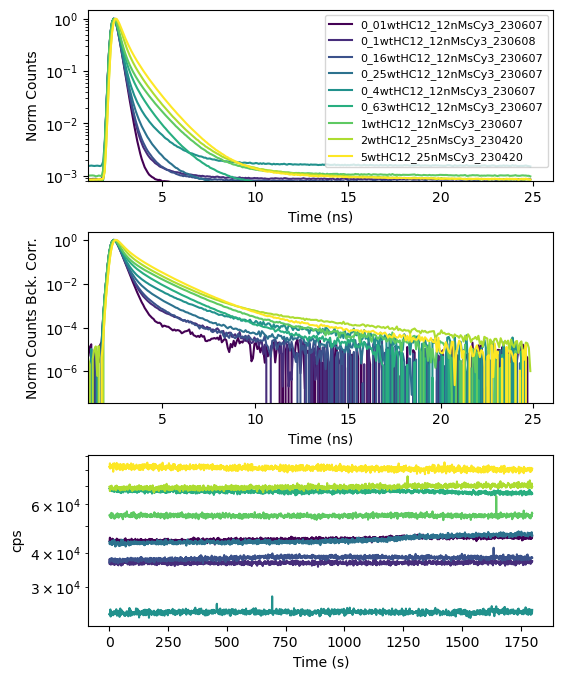

In [7]:
n = decays.shape[1]
fig, ax = plt.subplots(3,1, figsize=((6,8)))
fig.subplots_adjust(hspace=.3)

ax[0].set_prop_cycle('color',[plt.cm.viridis(i) for i in np.linspace(0, 1, n)])
ax[0].semilogy(decay_times[:-5,:], decays[:-5,:]  / np.nanmax(decays[:,:],axis=0))
ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('Norm Counts')
ax[0].set_ylim(8e-4)
ax[0].set_xlim(1,)
ax[1].set_prop_cycle('color',[plt.cm.viridis(i) for i in np.linspace(0, 1, n)])
ax[1].semilogy(decay_times[:-5,:], (decays[:-5,:] - decays[10,:]) / np.nanmax(decays[:,:] - decays[10,:],axis=0))
ax[1].set_xlabel('Time (ns)')
ax[1].set_ylabel('Norm Counts Bck. Corr.')
ax[1].set_ylim()
ax[1].set_xlim(1,)

ax[2].set_prop_cycle('color',[plt.cm.viridis(i) for i in np.linspace(0, 1, n)])
ax[2].semilogy(int_times, int_cps)
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('cps')
ax[0].legend(df.pickle_name,fontsize=8)


## Shrinking Gate Fluorescence Correlation Spectroscopy Processing
In shrinking gate fluorescence correlation spectroscopy (sgFCS) we calculate the autocorrelation function $G(\tau,t_\text{g})$ for increasingly smaller subset of photons set by gate time, $t_\text{g}$:
$$ G(\tau,t_\text{g}) = \frac{\langle I(t,t_\text{g})I(t + \tau ,t_\text{g}) \rangle}{\langle I(t,t_\text{g}) \rangle ^2} $$

where $I(t)$ is the intensity at time  $t$ and $\tau$ is the lag time. Here, $t_\text{g}$ refers to the photon arrival time relative to the pulse, i.e. the micro-time

We take advantage of a Python/Cython implementation of the algorithm from Wahl et al (Optics Express,2003,11,3583) for calculating: $G(\tau)$ from TCSPC data
https://github.com/dwaithe/FCS_point_correlator / doi: 10.1093/bioinformatics/btv687

```python
from focuspoint.correlation_methods.correlation_methods import tttr2xfcs
```

Our code performs sgFCS by filtering the microtime array for increasingly large values of $t_\text{g}$ and supplying the filtered array to tttrx2xfcsc

The rest of the code largely just automates process to various degrees

### ShrinkFitter Class and Data Visualisation
Data is processed using the ShrinkFitter class. This class contains the processed sgFCS data, the necessary functions for processing, and the corresponding TCSPC data for comparison if wanted. When processing data we specify a range of start gates, instead of a range $t_\text{g}$ values, as well as the number of steps to perform. By default we process from $t_\text{g}$ up to the 5th last gate to counting artefacts in the last TCSPC bin, but other maximum values can be specified.

To choose an appropriate range of start gates we choose the condition with the longest average lifetime and plot chosen start gates

In [97]:
file = 'filenames_ibidi_Conc_full.xlsx'
df = pd.read_excel(file)
num = 8
path = df.paths[num]
decay = decays[:,num]
decaytime = decay_times[:,num]
micro_res = (decay_times[150,num] - decay_times[100,num])/50
start_gate_low = 25
start_gate_high = 100
n_steps = 10
fitter = ShrinkFitter(path=path,xstart=start_gate_low,xend=start_gate_high,nsteps=n_steps, micro_res=micro_res,decay=decay,decay_time=decaytime, bckg=False)

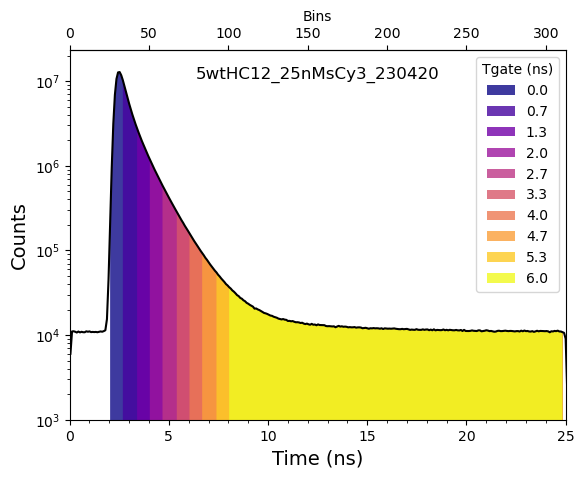

In [9]:
fig, ax = plt.subplots()
n = n_steps
ax.set_prop_cycle('color',[plt.cm.plasma(i) for i in np.linspace(0, 1, n)])
decay = fitter.decay
decaytime = fitter.decay_time


micro_res = fitter.micro_res
gates = np.linspace(start_gate_low,start_gate_high,n)

for i in range(n):
    ax.fill_between(decaytime[:-5],decay[:-5], where = decaytime[:-5] > gates[i]*micro_res,alpha=0.8)

ax.semilogy(decaytime[:-1],decay[:-1],'k')
secax = ax.secondary_xaxis(1, functions=(lambda x: x / micro_res, lambda x: x * micro_res ))
secax.set_xlabel('Bins')

leg = np.around(np.linspace(0,start_gate_high - start_gate_low,n)*micro_res,1)
plt.legend(leg,title='Tgate (ns)',loc='upper right')
plt.title(df.pickle_name[num],y=0.9)

plt.ylim(1e3,)
plt.xlim(0,25)
ax.set_xlabel('Time (ns)',fontsize=14)
ax.set_ylabel('Counts',fontsize=14)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())


#### Single shrinking gate
sgFCS is typically performed with the shrinkChop routine. At each $t_\text{g}$, the original data is chopped into a number of even macro-time slices and $G(\tau)$ is calculated for each slice. We choose 10 slices which satisfies $slice length> 10^5\tau_\text{D}$ (see https://iopscience.iop.org/article/10.1088/1367-2630/12/11/113009) for all conditions except 5 wt% HEUR.

A modified version of the alogrithm of Ries, J. et al. Optics Express 2010, 18 (11), 11073 is used to is used to exclude slices where the ratio of the average deviation of $G(\tau)$ relative to the minimum deviation is larger than a split ratio. The mean and stdev of $G(\tau)$ for all slices and the accepted slices, as well as the individual $G(\tau)$, are stored in the fitter object. A range of split ratios should be tested to see their effect on the fitted diffusion coefficients. 

In [43]:
#TCSPC data are not 
dTimeArr, trueTimeArr, subChanArr, micro_res = loader(fitter.path)
n_slice = 20
split = 10
fitter.shrinkChop(subChan=subChanArr,tTime=trueTimeArr,dTime=dTimeArr,n_slice=n_slice,comb_filt=None,split=split)

TCSPC Hardware: MultiHarpNT3


KeyboardInterrupt: 

#### Batch sgFCS Example
All PTU files in the dataframe can be batch processed using the batch_class_chop function. Each file is stored as its own fitter object for later analysis. Options such as background correction, smoothing, and selecting a subrange of files are described in the function docstring.


In [ ]:
xstart = 25
xend = 100
n_steps = 10
n_slice = 20
split = 10
folder = 'supp'
batch_class_chop(df,xstart=xstart,xend=xend,nsteps=n_steps,n_slice=n_slice,, folder=folder, split=split)

#### Comparison of $G(\tau)$ from Complete and Accepted Subset
In our sgFCS experiments, the algorithm for excluding curves that differ significantly from the average doesn't affect the average autocorrelation value significantly. However as seen below, their is a significant reduction in the standard deviation used to weight subsequent fits.

Text(0.5, 1.0, 'All (closed), Accepted (open)')

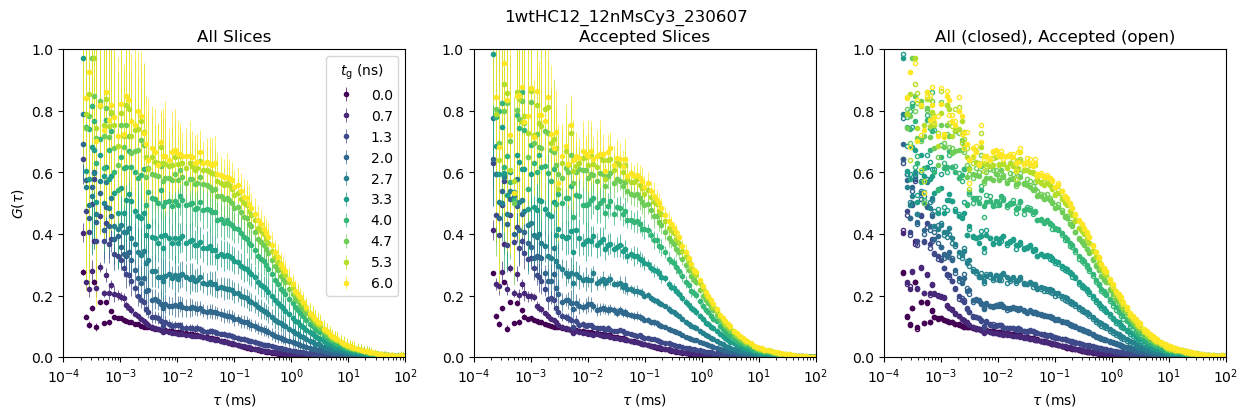

In [58]:
file = 6
folder = 'sub' + '/'
split = 10
split = split if split != None else ''
with open(f'{folder}{df.pickle_name[file]}{split}.bin','rb') as f:
    data = pickle.load(f)

ind = np.where(data.autoTimes > 0.01)[0][0]
n = data.autoTimes.shape[1]

fig, ax = plt.subplots(1,3,figsize=(15,4))

fig.suptitle(df.pickle_name[file])
ax[0].semilogx()
ax[1].semilogx()

for axis in ax:
    axis.set_prop_cycle('color',[plt.cm.viridis(i) for i in np.linspace(0, 1, n)])
    axis.set_ylim(0,1)
    axis.set_xlim(1e-4,1e2)
    axis.set_xlabel(r'$\tau$ (ms)')

colors = [[plt.cm.viridis(i),plt.cm.viridis(i)] for i in np.linspace(0, 1, n)]
colors = [color for sublist in colors for color in sublist]
ax[2].set_prop_cycle('color',colors)

for ind in range(n):
    ax[0].errorbar(data.autoTimes[:,ind],data.autoCorrsNorm[:,ind],yerr=data.autoCorrsStd[:,ind],
                   elinewidth=0.5,linestyle='None',marker='.')
    ax[1].errorbar(data.autoTimes[:,ind],data.autoCorrsNormSub[:,ind],yerr=data.autoCorrsStdSub[:,ind],
                   elinewidth=0.5,linestyle='None',marker='.')
    ax[2].semilogx(data.autoTimes[:,ind],data.autoCorrsNorm[:,ind],
                   linestyle='None',marker='.')
    ax[2].semilogx(data.autoTimes[:,ind],data.autoCorrsNormSub[:,ind],
                   linestyle='None',marker='.',fillstyle='none')


ax[0].set_ylabel(r'$G(\tau)$')

ax[1].set_xlabel(r'$\tau$ (ms)')

leg = np.around(np.linspace(0,data.xend - data.xstart,n)*data.micro_res,1)
ax[0].legend(leg,title=r'$t_\mathrm{g}$ (ns)')

ax[0].set_title('All Slices')
ax[1].set_title('Accepted Slices')
ax[2].set_title('All (closed), Accepted (open)')




## INTERNAL REMOVE FOR PUBLICATION 
## Intensity Trace Filtering 
In some experiments intensity changes slower than the time scale of diffusion can occur (e.g. photobleaching or sample movement in biological samples). We can correct for this by creating a smoothing function $f(t)$ that approximates the slow changes in intensity. We can use this to correct the intensity, $I(t)$, while mainting the correct variance at small time scales with the following equation from [Ries et al 2010](https://iopscience.iop.org/article/10.1088/1367-2630/12/11/113009/pdf):
$$ I_\text{corrected}(t) = \frac{I(t)}{\sqrt{\frac{f(t)}{I(0)}}} + I(0)\left( 1 - \sqrt{\frac{f(t)}{I(0)}} \right) $$

As the corrected meant intensity is constant, we can apply a threshold function to remove large spikes in intensity that are usually associated with rare events such as aggregates or dust passing through the confocal volume.

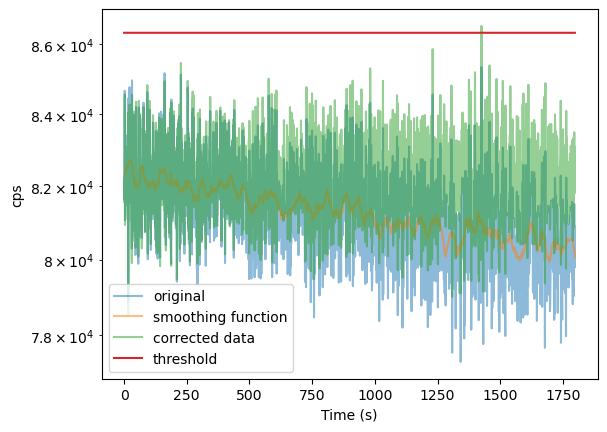

In [68]:
counts,timeSeries, bins = delayTime2bin(trueTimeArr/1e9,subChanArr,1,1)
smoother = savgol_filter(counts,50,3)
corrected = counts/np.sqrt(smoother/counts[0])+counts[0]*(1 - np.sqrt(smoother/counts[0])) #Variance conserving correction

alph = 0.5
plt.semilogy(timeSeries,counts,alpha=alph,label='original')
plt.semilogy(timeSeries,smoother,alpha=alph,label='smoothing function')
plt.semilogy(timeSeries,corrected2,alpha=alph,label='corrected data')
plt.semilogy(np.ones(len(timeSeries))*counts[0]*1.05,label='threshold')

plt.xlabel('Time (s)')
plt.ylabel('cps')
plt.legend()

## Background Correction
The background correction algorithm implemented in the ShrinkFitter class calculates the background from the average of the first $n$ bins. This is then subtracted from the experimental decay to yield the fluorescence pattern. The background and fluorescence are combined to generate a filter that can be used to statistically weight the correlation algorithm. In principal filters could be generated from a series of lifetime components as per fluorescence lifetime correlation spectroscopy. However, this has not been implemented yet.

Wohland, T.; Maiti, S.; Macháň, R. An Introduction to Fluorescence Correlation Spectroscopy:; IOP Publishing, 2020. https://doi.org/10.1088/978-0-7503-2080-1.

In [7]:
file = 6
dTimeArr, trueTimeArr, subChanArr, micro_res = loader(df.paths[file])
with open('decays_supp.bin','rb') as f:
    int_cps, int_times, decays, decay_times = pickle.load(f)

TCSPC Hardware: MultiHarpNT3
Raw Data has been Read!



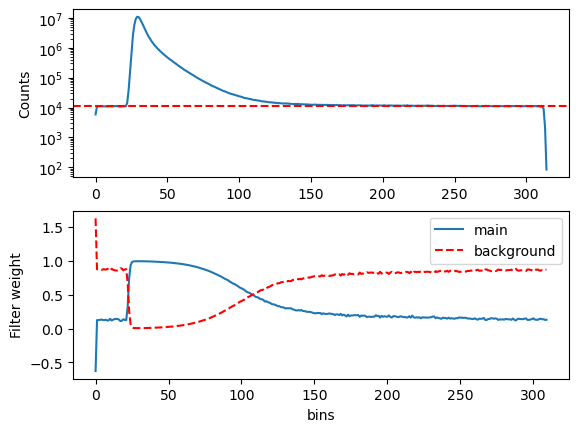

In [67]:
filt_mat,_ = bckg_filter(dTimeArr,subChanArr,bck_max=20)
fig,ax = plt.subplots(2,1)
ax[0].semilogy(decays[:,file])
ax[0].axhline(np.mean(decays[2:20,file]),linestyle='--',color='r')
ax[0].set_ylabel('Counts')


ax[1].plot(filt_mat[1,:-5],label='main')
ax[1].plot(filt_mat[0,:-5],linestyle='--',color='r',label='background')
ax[1].set_ylabel('Filter weight')
ax[1].set_xlabel('bins')

plt.legend()

## Shrinking Gate FCS Curve Fitting
The autocorrelation function of a species diffusing through a 3D Gaussian confocal volume, $G_\text{D}(\tau)$  can be represented by:
$$ G_\text{D}(\tau) = \frac{1}{N}\sum_i^n f_i \frac{1}{\left(1 + \frac{\tau}{\tau_i} \right)} \frac{1}{\left(1 + \frac{\tau}{K^2\tau_i} \right)^{0.5}}$$
where $N$ is the number of molecules, $n$ is the number of diffusing species, $K$ is the calibrated aspect ratio of the confocal volume, and $f_i$ and $\tau_i$  are the fraction and characteristic diffusion time of species $i$, respectively. NB that from multiple species, this equation is only true if the brightness of each species is identical. If they are not identical only $N$ and $f_i$ will be distorted. Extended equations that incorporate non-equal brightness exist, but have not been implemented yet.

We represent the contribution of fast exponential processes (e.g. photoisomerisation of sCy3 dye from light to dark state or triplet processes) by:
$$ G_\text{fast}(\tau) = \left(1 + \frac{f}{1-f}e^{-\frac{\tau}{\tau_\text{fast}}} \right) $$
where $f$ is the fraction of molecules in the dark state, and $\tau_\text{fast}$ is the characteristic relaxation time.

Assuming the two processes considered are well separated in time, the overall autocorrelation function is:
$$ G(\tau) = G_\text{fast}(\tau)G_\text{D}(\tau) + G_\infty $$
where $G_\infty$ is a baseline offset accounting for non-ideal decays.

For more information see a review text such as Wohland, T.; Maiti, S.; Macháň, R. An Introduction to Fluorescence Correlation Spectroscopy:; IOP Publishing, 2020.
https://doi.org/10.1088/978-0-7503-2080-1.

For fitting, the equations above are implemented in a form suitable for use with the lmfit package.

### Fitting Data from a Single Time Gate
To fit data, we first open the stored ShrinkFitter class object that contains the collection of autocorrelation curves and select a gate index to analyse. There are some systematic errors and artefacts at lower values of $\tau$ that may arise from the asynchronous nature of the data collection. Therefore the datarange is truncated before processing.

In [71]:
file = 6
folder = 'scaled_data' + '/' #change to 
split = 10
split = split if split != None else ''
with open(f'{folder}{df.pickle_name[file]}{split}.bin','rb') as f:
    data = pickle.load(f)

gate = 3

#Lists of calibration values specific to HEUR data in paper. 
r6g = 7*[0.0624] + 2*[0.05077]
K =  7*[6.447] + 2*[5.8]

#Outputted autocorrelation gates have systematic so we only analyse a subset of the total data array
x_orig = data.autoTimes[:,gate]
y_orig = data.autoCorrsNormSub[:,gate]*data.scales[gate] #multiply curves by background correction scaling factor
wgt_orig = data.autoCorrsStdSub[:,gate]*data.scales[gate] #multiply curves by background correction scaling factor
#Remove Negative Correlation Values
x = x_orig[y_orig>-0.5]
wgt = wgt_orig[y_orig >-0.5]
y = y_orig[y_orig>-0.5]
#Remove 
x_min = 10e-4
wgt = wgt[x > x_min]
y = y[x > x_min]
x = x[x > x_min]
wgt = 1/wgt

To fit the data we create a model from our user-defined autocorrelation functions using the [lmfit package](https://lmfit.github.io/lmfit-py/model.html). In this paper we have called this model "trip", but any suitable name can be used.

To use the model we create a parameters object and set the initial parameter values, determine whether they vary during fitting (True/False), their min and max values, and any relationships between parameters if necessary.

In [26]:
n_diff = 1

params = Parameters()
if (n_diff == 1):
    trip = Model(triplet) * Model(diff_3D) + Model(baseline,independent_vars=['tau'])
    #Alternative if you want to sum the models
    # trip = Model(triplet_sum) + Model(diff_3D) + Model(baseline,independent_vars=['tau'])
    params.add_many(('f_fast',0.1,True,0,0.99,None,None),
                    ('tau_fast',3e-4,True,1e-6,5e-3,None,None),
                    ('N',10,True,1e-4,1e3,None,None),
                    ('tau_diff',0.0707,True,1e-2,10,None,None),
                    ('K',K[file],False,1,10,None,None),
                    ('G_inf',0.01,True,-0.1,1e5,None,None),
                    ('N2',1,False,1e-4,1e3,'N',None)) #This parameter is only necessary if 
else:
    trip = Model(triplet) * Model(double_diff_3D) + Model(baseline,independent_vars=['tau'])
    params.add_many(('f_fast',0.1,True,0,0.99,None,None),
                ('tau_fast',1e-3,True,1e-5,5e-3,None,None),
                ('N',10,True,1e-4,1e3,None,None),
                ('frac_1',0.1,True,0,0.99,None,None),
                ('tau_diff1',0.0869,False,1e-2,10,None,None),
                ('tau_diff2',0.5,True,1e-1,10,None,None),
                ('K',K[file],False,1,10,None,None),
                ('G_inf',0.01,True,-0.1,0.1,None,None))

In most cases these initial parameters are sufficient for all data in the study, therefore for we can use the paramser function to return the model and a suitable set of parameters.

In [73]:
tau_diff1 = 0.0921 #turn this into a vector
n_diff = 1

trip,params = paramser(n_diff,tau_diff1,K[file])


From the model ojbect, we can use the fit function to perform a least_squares optimisation of the data. As seen below, this is usally sufficient to fit the data with a poor initial guess.

In [78]:
result = trip.fit(y,tau=x, params=params,nan_policy='omit',weights=wgt)

In [83]:
print(result.fit_report())

[[Model]]
    ((Model(triplet) * Model(diff_3D)) + Model(baseline))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 107
    # variables        = 5
    chi-square         = 64.6238173
    reduced chi-square = 0.63356684
    Akaike info crit   = -43.9543009
    Bayesian info crit = -30.5901567
    R-squared          = -15.8881127
[[Variables]]
    f_fast:    0.70264340 +/- 0.02234237 (3.18%) (init = 0.1)
    tau_fast:  0.00171477 +/- 1.7360e-04 (10.12%) (init = 0.001)
    N:         3.19212775 +/- 0.02911139 (0.91%) (init = 2)
    tau_diff:  0.44407156 +/- 0.00848990 (1.91%) (init = 0.07)
    K:         6.447 (fixed)
    G_inf:     3.1749e-04 +/- 1.2346e-04 (38.88%) (init = 0.01)
    N2:        3.19212775 +/- 0.02911139 (0.91%) == 'N'
[[Correlations]] (unreported correlations are < 0.100)
    C(f_fast, tau_fast)   = -0.872
    C(N, tau_diff)        = 0.815
    C(tau_diff, G_inf)    = -0.323
    C(tau_fast, N)        = 0.254
    C(t

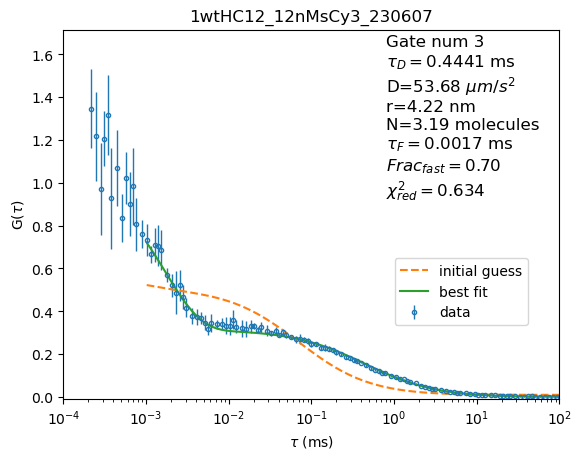

In [79]:
fig,ax = plt.subplots()

ax.errorbar(x_orig,y_orig,yerr=wgt_orig,linestyle='None',elinewidth=1,marker='.',fillstyle='none',label='data')
ax.semilogx(x,result.init_fit,'--',label='initial guess')
ax.semilogx(x,result.best_fit,'-',label='best fit')
ax.set_ylabel(r'G($\tau$)')
ax.set_xlabel(r'$\tau$ (ms)')


ax.set_title(df.pickle_name[file])
ax.set_ylim(-0.01,)
ax.set_xlim(1e-4,100)

if (n_diff == 1):
    Diff = diff2(result.params['tau_diff'].value,0.0624)
    R = stokes_R(Diff)
    diff_text = '\n'.join((
        r'Gate num %.0f' % (gate),
        r'$\tau_D=%.4f$ ms' % (result.params['tau_diff'].value),
        r'D=%.2f $\mu m /s^2$' % (Diff),
        r'r=%.2f nm' % (R),
        r'N=%.2f molecules' % (result.params['N']),
        r'$\tau_F=%.4f$ ms' % (result.params['tau_fast'].value),
        r'$Frac_{fast}=%.2f$' % (result.params['f_fast']),
        r'$\chi^2_{red}=%.3f$' % (result.redchi)))
    ax.text(0.65,0.55,diff_text,transform=ax.transAxes,fontsize=12)
else:
    Diff = diff2(result.params['tau_diff2'].value,0.0624)
    R = stokes_R(Diff)
    diff_text = '\n'.join((
        r'Gate num %.0f' % (gate),
        r'$\tau_D=%.4f$ ms' % (result.params['tau_diff2'].value),
        r'D=%.2f $\mu m /s^2$' % (Diff),
        r'r=%.2f nm' % (R),
        r'N=%.2f molecules' % (result.params['N']),
        r'$\tau_F=%.4f$ ms' % (result.params['tau_fast'].value),
        r'$Frac_{free}=%.4f$' % (result.params['frac_1'].value),
        r'$Frac_{fast}=%.2f$' % (result.params['f_fast']),
        r'$\chi^2_{red}=%.3f$' % (result.redchi)))
    ax.text(0.65,0.4,diff_text,transform=ax.transAxes,fontsize=12)

plt.legend(loc='upper right',bbox_to_anchor=(0.95,0.4))

To get a better idea of the posterior probability distributions of the fit parameters we use the emcee Markov chain Monte Carlo sampler (e.g. [fitting a line](https://emcee.readthedocs.io/en/stable/tutorials/line/).) In simplified terms, this approach creates a series of walkers which contain a set of parameter values. These walkers are init
using the optimised parameters from the least-squares fit. Each walker takes steps across the parameter space forming a Markov chain and tend to spend more time in areas of higher likelihood as they explore the parameter space.

In [82]:
emcee_kws = dict(steps=3000, burn=500, thin=20, is_weighted=True,progress=True)
result_emcee = trip.fit(y,tau=x, params=result.params.copy(),nan_policy='omit',weights=wgt, method='emcee',fit_kws=emcee_kws)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:52<00:00, 57.55it/s]


In [81]:
print(result_emcee.fit_report())

[[Model]]
    ((Model(triplet) * Model(diff_3D)) + Model(baseline))
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 200000
    # data points      = 107
    # variables        = 5
    chi-square         = 64.6547115
    reduced chi-square = 0.63386972
    Akaike info crit   = -43.9031605
    Bayesian info crit = -30.5390163
    R-squared          = -15.8961863
[[Variables]]
    f_fast:    0.69763313 +/- 0.02970694 (4.26%) (init = 0.7026434)
    tau_fast:  0.00175178 +/- 2.3678e-04 (13.52%) (init = 0.001714775)
    N:         3.19273556 +/- 0.03751287 (1.17%) (init = 3.192128)
    tau_diff:  0.44442951 +/- 0.01106370 (2.49%) (init = 0.4440716)
    K:         6.447 (fixed)
    G_inf:     3.1401e-04 +/- 1.5467e-04 (49.26%) (init = 0.0003174887)
    N2:        3.19273556 == 'N'
[[Correlations]] (unreported correlations are < 0.100)
    C(f_fast, tau_fast)   = -0.873
    C(N, tau_diff)        = 0.828
    C(tau_diff, G_inf)    = -0.329
    C(tau_fast, N)        = 0.

To check that the ensemble of walkers have taken enough steps to sample the parameter space and "forget" their initial values, we can plot the parameters for each walker at each time-step. We can see that the parameters are bunched together initially, but quickly diverge after a "burn-in" period. We discard points from this initial burn-in period for subsequent analysis.

Text(0.5, 0, 'steps')

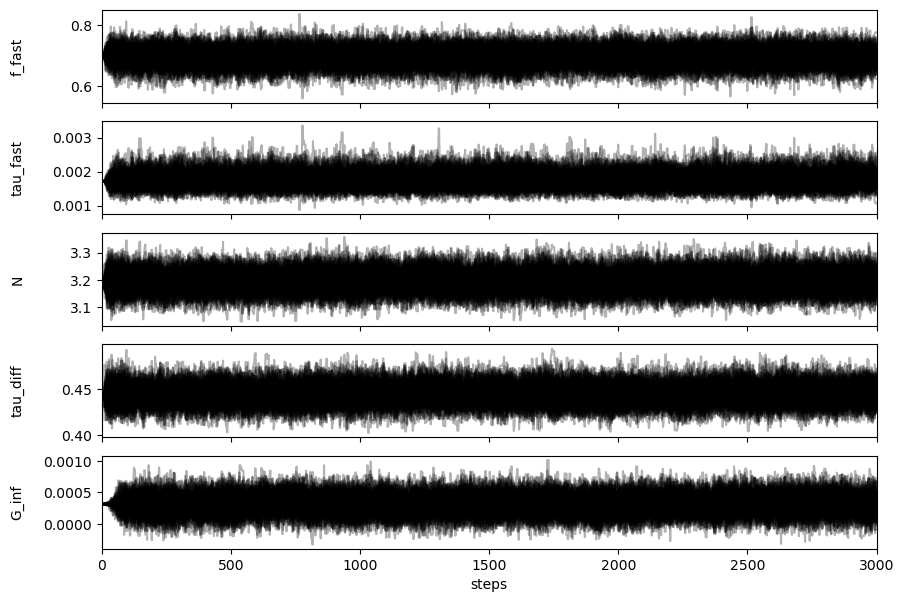

In [95]:
samples = result_emcee.sampler.get_chain()
ndim = samples.shape[2]
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = result_emcee.var_names
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
ax.set_xlabel('steps')

Another diagonstic we can plot is the projection of our results into the space of the observed data. To do this we pick a random set of parameters from the chain (in this case 500) and plot them with a transparency/alpha value of 0.05. In the example below we see that all samples closely agree in the diffusive region of autocorrelation curve ($\tau > 10^{-2}$), while there is a large variation in the exponential region.

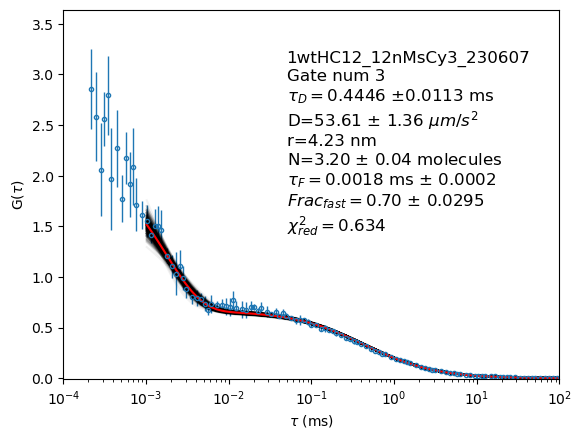

In [89]:
plot_emcee(df=df, x_orig=x_orig, y_orig=y_orig, wgt_orig=wgt_orig, x=x, result_emcee=result_emcee, name=df.pickle_name[file],
           curve=gate, tau_R6G=0.0624, file=file, n_diff=n_diff, trip=trip, scale=True, scale_val=data.scales[gate])

To invesitgate the relationship between the parameters we can the corner package to make a plot of the 1D and 2D projections of the posterior probability distribution for each parameter. In this case we see that the probability distribution of each parameter is largely normally distributed. Furthermore there is an inverse correlation between tau_fast and f_fast, while there is a positive correlation between tau_diff and N.

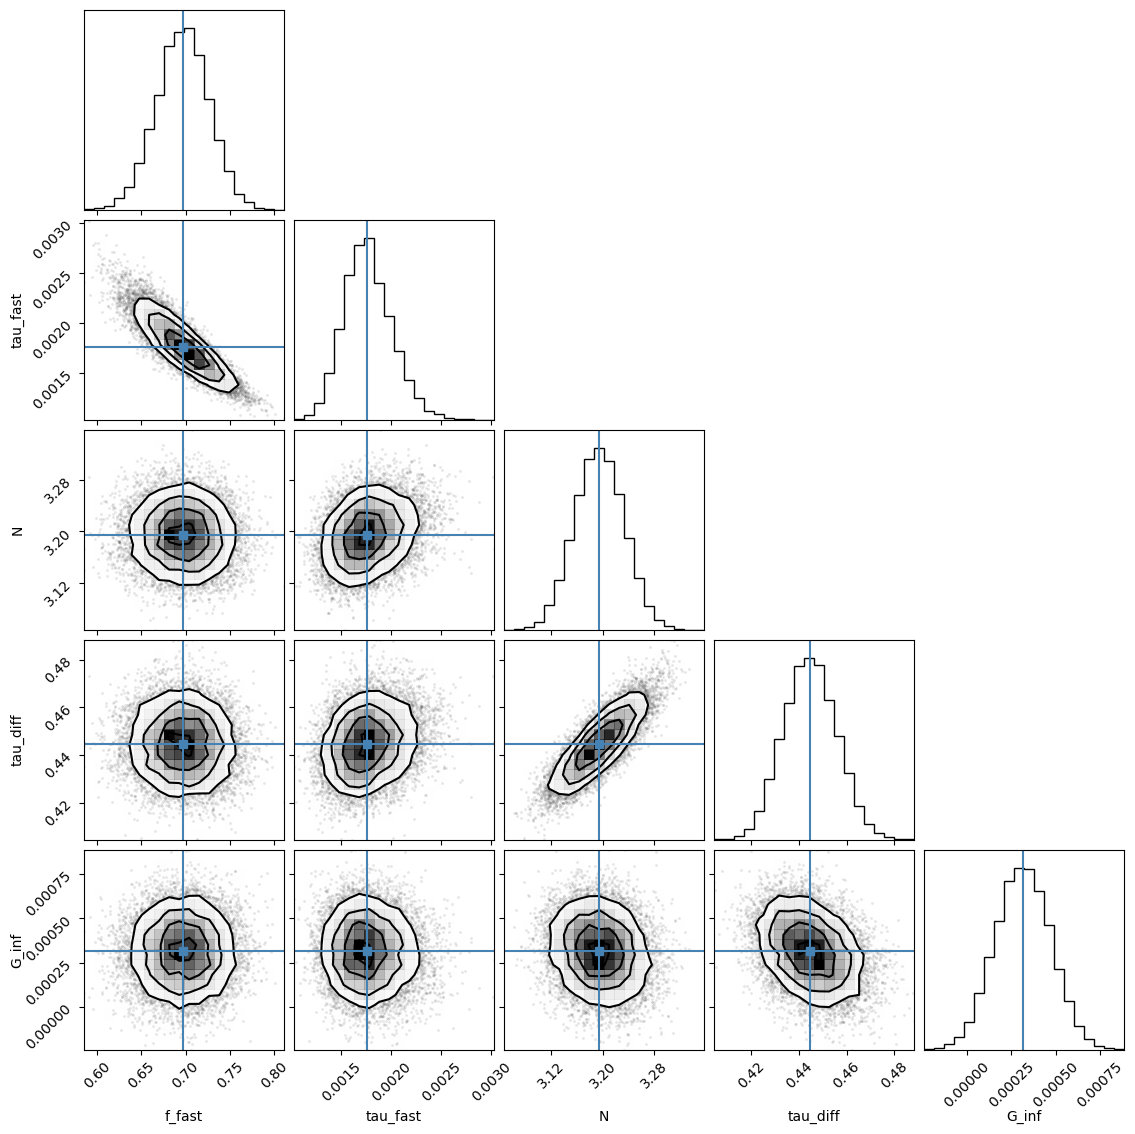

In [92]:
emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names,
                             truths=[result_emcee.values[free] for free in result_emcee.var_names])

Similar to the sgFCS autocorrelation generation, we can batch fit the data. To do this we create another excel file that contains the location for the data and the results, as well as the datafile suffix, number of diffusing species and any relevant calibration data. The batch processing will produce an excel file with the optimised parameters at each $t_\text{g}$, their corresponding error and the $\chi^2_\text{red}$. It will also save the plotted MCMC samples annotated with key fit parameters.

NB tau_diff1 is selected using the reverse shrinking gate method described in the supplemntary information. To run this approach use  `fitter.revShrinkGateChop(subchan,tTime,dTime,n_slice,comb_filt,split)` or the corresponding `batch_class_revshrinkchop()`

In [98]:
df = pd.read_excel('filenames_ibidi_Conc_full.xlsx')
batch = pd.read_excel('batch_fit_scale.xlsx')
batch

,file,dat_folder,res_folder,suff,n_diff,tau_diff1,sub,K,tau_R6G
0,0,scaled_data/,scaled_results/,10,1,0.0745,True,6.447,0.06240
1,1,scaled_data/,scaled_results/,10,1,0.0739,True,6.447,0.06240
2,2,scaled_data/,scaled_results/,10,1,0.0707,True,6.447,0.06240
3,3,scaled_data/,scaled_results/,10,1,0.0874,True,6.447,0.06240
4,4,scaled_data/,scaled_results/,10,1,0.0754,True,6.447,0.06240
5,5,scaled_data/,scaled_results/,10,1,0.0939,True,6.447,0.06240
6,6,scaled_data/,scaled_results/,10,1,0.0921,True,6.447,0.06240
7,7,scaled_data/,scaled_results/,10,1,0.1043,True,5.800,0.05077
8,8,scaled_data/,scaled_results/,10,1,0.1658,True,5.800,0.05077
9,0,scaled_data/,scaled_results/,10,2,0.0745,True,6.447,0.06240


In [ ]:
for _,row in batch.iterrows():
    batcher(df,file=row['file'],dat_folder=row['dat_folder'],res_folder=row['res_folder'],
            suff = row['suff'],steps = 2000,n_diff = row['n_diff'],tau_diff1 = row['tau_diff1'],
            K=row['K'],sub=row['sub'],tau_R6G=row['tau_R6G'],scale=True)